In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it
from sklearn.neighbors import LocalOutlierFactor

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_raphe"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_raphe-affinity_cosine"

In [4]:
dataset = "2020-09-29-2"
estim = "data008/data008-all"
estim_1elec = "data003"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [7]:
def binaryClustering(X, y, T, R2_thr=0.1, min_points_per_cluster=30, child='', verbose=False):
    if verbose:
        print(child)
        print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
    nll_MLE_init = results_init.fun

#     log_reg = sm.Logit(y_bin_init, X_bin_init).fit()
    
    ybar = np.mean(y_bin_init)
    beta_null = np.log(ybar / (1 - ybar))
    null_weights = np.concatenate((np.array([beta_null]), np.zeros(X.shape[-1])))
    nll_null = fitting.negLL(null_weights, X_bin_init, y_bin_init, False, 'none')
    
    R2 = 1 - nll_MLE_init / nll_null
#     print(log_reg.summary())

    if verbose:
        print(R2)

    if len(X) >= min_points_per_cluster and R2 >= R2_thr:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='left', verbose=verbose) + binaryClustering(X[cluster1], y[cluster1], T[cluster1], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='right', verbose=verbose) 

In [8]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [9]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, spont_limit=0.2, noise_limit=0.1, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit=spont_limit, noise_limit=noise_limit)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [20]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, downsample=False, downsample_trials=10, downsample_factor=2,
                        load_from_mat=True, R2_thr=0.1, min_points_per_cluster=15,
                        show_plots=False, verbose=False):
    weights = []
    amps = []
    probs = []
    
    for cell in cells:
        X, y, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)

        clf = LocalOutlierFactor(n_neighbors=100)
        clf.fit_predict(X)
        inds = np.where(clf.negative_outlier_factor_ >= -1.05)[0]
        
        X = X[inds]
        y = y[inds]

        amps.append(X)
        probs.append(y)
        
        output = binaryClustering(X, y, T, R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, verbose=verbose)
        
        cell_weights = []
        for i in range(len(output)):
            if verbose:
                print(output[i][2])

            if len(output[i][2]) > 1:
    #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
    #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

    #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    #             print(OLS_w)

                cell_weights.append(output[i][2])

                if show_plots:
                    normal = output[i][2][1:]

                    d = output[i][2][0]
                    xmin = np.amin(output[i][0][:, 0])
                    xmax = np.amax(output[i][0][:, 0])
                    ymin = np.amin(output[i][0][:, 1])
                    ymax = np.amax(output[i][0][:, 1])

                    # create x,y
                    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

                    # calculate corresponding z
                    z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
                    z[z > 1.8] = np.nan
                    z[z < -1.8] = np.nan

                    # plot the surface
                    fig = plt.figure()
                    fig.clear()
                    ax = Axes3D(fig)
                    ax.plot_surface(xx, yy, z, alpha=0.5)
                    plt.xlabel(r'$I_1$')
                    plt.ylabel(r'$I_2$')
                    plt.xlim(-1.8, 1.8)
                    plt.ylim(-1.8, 1.8)
                    ax.set_zlim(-1.8, 1.8)
                    ax.set_zlabel(r'$I_3$')

                    scat = ax.scatter(output[i][0][:, 0], 
                                      output[i][0][:, 1],
                                      output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

                    clb = plt.colorbar(scat)
                    plt.show()

        weights.append(np.array(cell_weights))
        
    return weights, amps, probs

In [21]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [22]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [23]:
def computeSelecVec(target_combos, nt_weights, I_max=1.78125, verbose=False):
    selec_vals = np.zeros(len(target_combos))
    x_vals = np.zeros((len(target_combos), 3))
    for i in range(len(target_combos)):
        if verbose:
            print(i)
        T_t = cp.Variable(1)
        T_n = cp.Variable(1)
        x = cp.Variable(3)

        constraints = [
            -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
            nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
            x[0] <= I_max,
            -I_max <= x[0],
            x[1] <= I_max,
            -I_max <= x[1], 
            x[2] <= I_max,
            -I_max <= x[2],  
        ]

        objective_function = cp.exp(T_n) + cp.exp(T_t)

        objective = cp.Minimize(objective_function)
        prob = cp.Problem(objective, constraints)
        opt_val  = prob.solve()
        if opt_val == np.inf:
            continue

        if verbose:
            print(f"Optimal value {opt_val}")

            print(f"optimal p_t {compute_pt(T_t.value)[0]}")
            print(f"optimal p_n {compute_pn(T_n.value)[0]}")
            print(f"optimal T_t {T_t.value[0]}")
            print(f"optimal T_n {T_n.value[0]}")
            print(x.value)

        selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
        x_vals[i] = x.value
        
    return selec_vals, x_vals

In [24]:
p = 2
all_cells = np.array([176, 179, 207], dtype=int)

In [25]:
all_targets, all_nontargets = all_combos(all_cells)

In [26]:
selec_comparison = []

0
[176] [179] ON/OFF


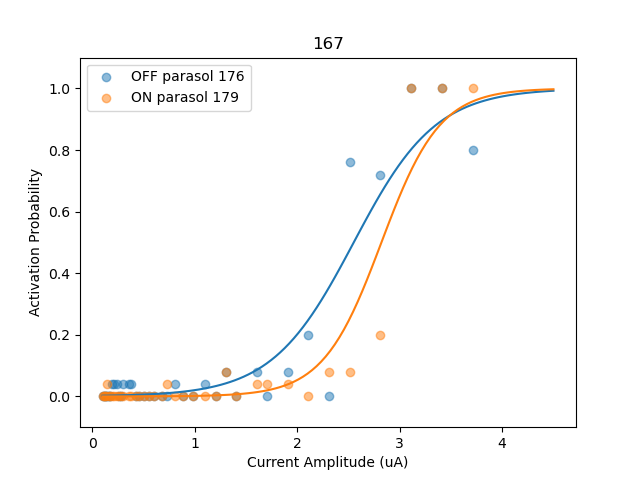

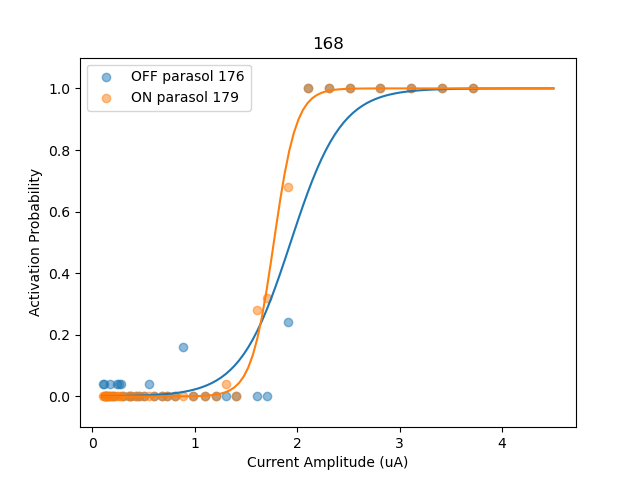

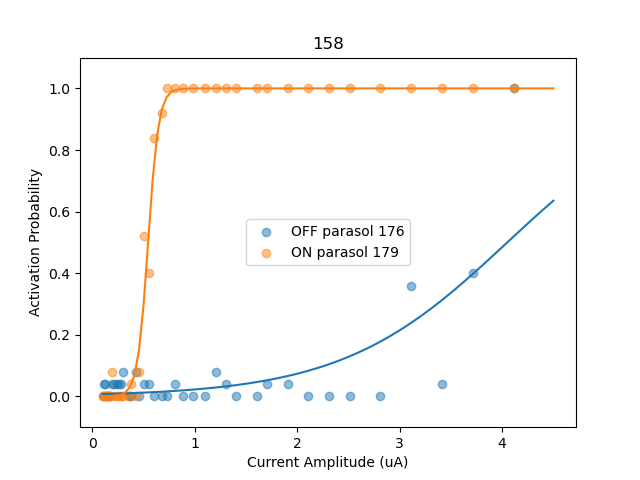

0.3632509971148007

2115
0.0007393645767305168
left
1048
0.0006686350124633922
left
612
0.007378308616611706
left
270
0.01693498700234619
left
127
0.0102854237269705
left
70
0.007208346898138429
left
52
0.024305077332501868
left
22
0.027134401426175736
right
30
0.02841059161394155
left
15
0.07097058839200898
right
15
0.015582817905966495
right
18
0.022898466456711675
right
57
0.021544640117414082
left
22
0.037407183225702134
right
35
0.04627417422034996
left
18
0.01821149482731621
right
17
0.04692164943002419
right
143
0.01247065200505204
left
92
0.043493496653857266
left
49
0.016604305715056333
left
27
0.010739168266876153
right
22
0.029592479834783192
right
43
0.16338404673504558
right
51
0.041661431179501496
left
29
0.08316830951189658
right
22
0.023334559458477067
right
342
0.012863001732422719
left
152
0.05630199610370368
left
80
0.055366581981765584
left
40
0.06801675882076885
left
21
0.028614055354098333
right
19
0.15005496553502462
right
40
0.03993863916588769
left
20
0.0442994

/tmp/ipykernel_48692/1134596097.py:61: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


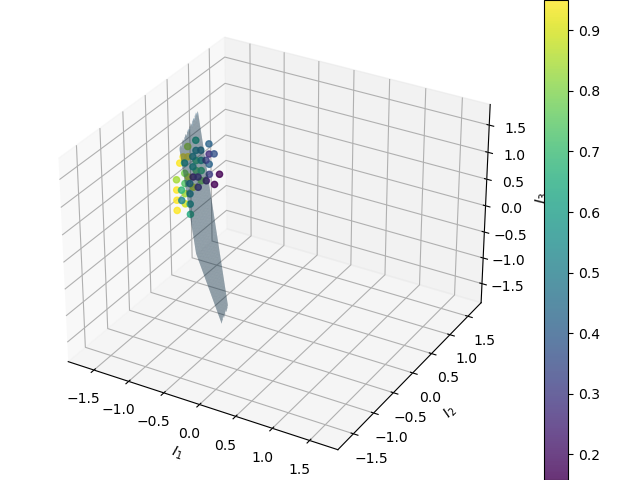

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-6.11693337  0.96052461  2.86576351  4.23988208]


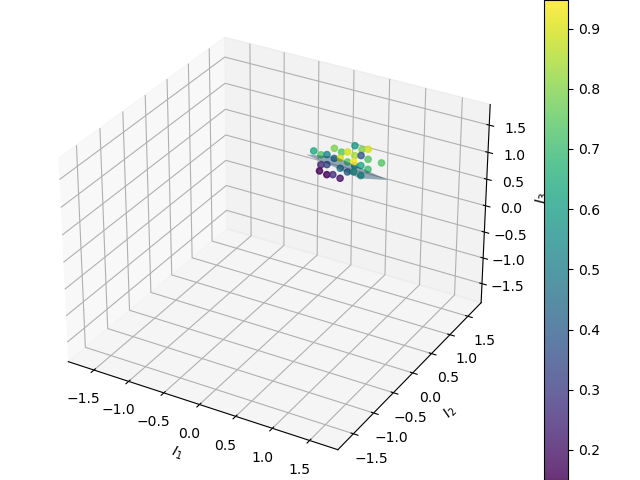

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-4.73883967 -6.09574815 -3.26260012 -2.04663078]


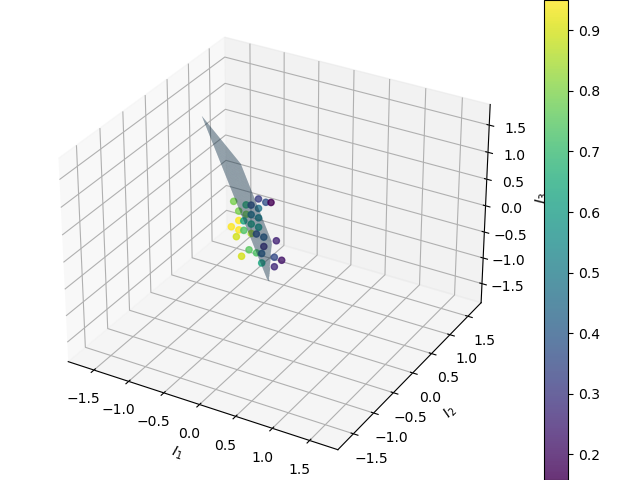

[nan]
[-3.77624507 -1.75201734 -0.32926199 -3.39875643]


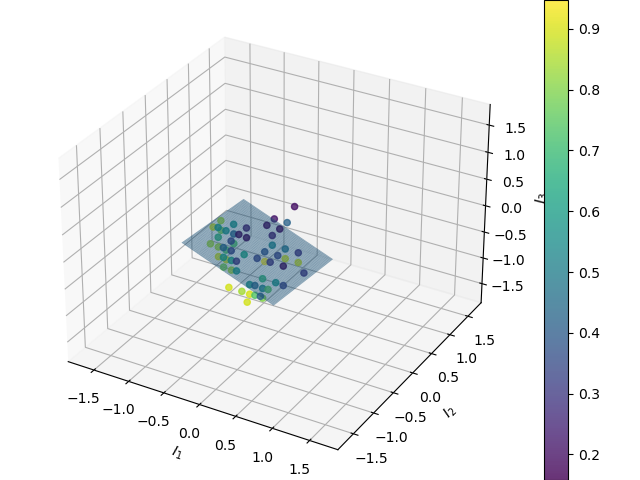

[nan]
[nan]
[nan]
[nan]
[nan]
[-5.04117111 -5.11504265 -1.69638789 -0.67373795]


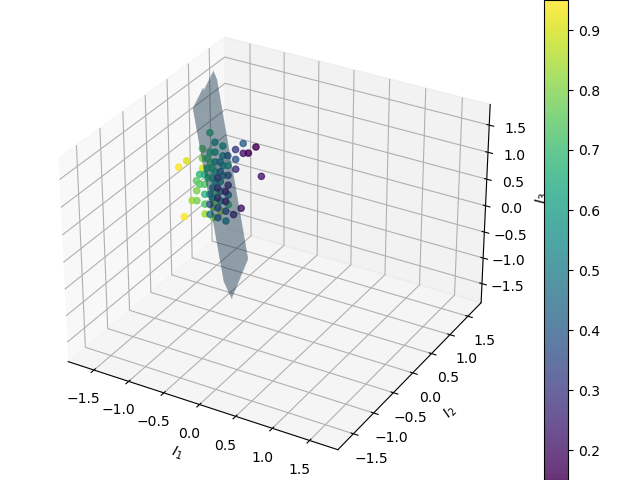

[-6.9217461   4.14542746  2.31773002  4.00407223]


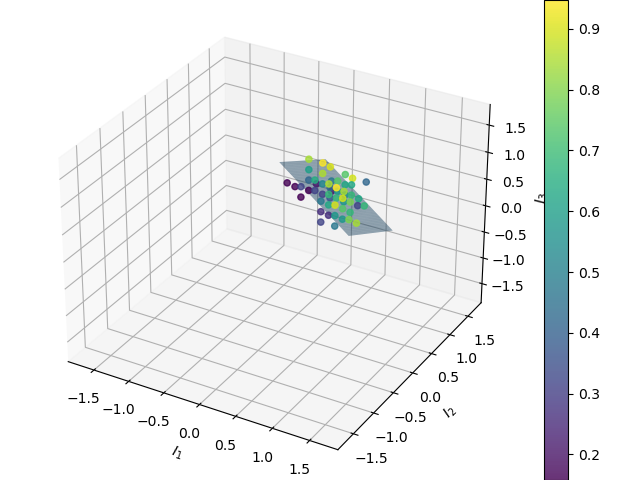

[nan]
[nan]
[-3.78550356  2.55605051  1.30325314  2.28320477]


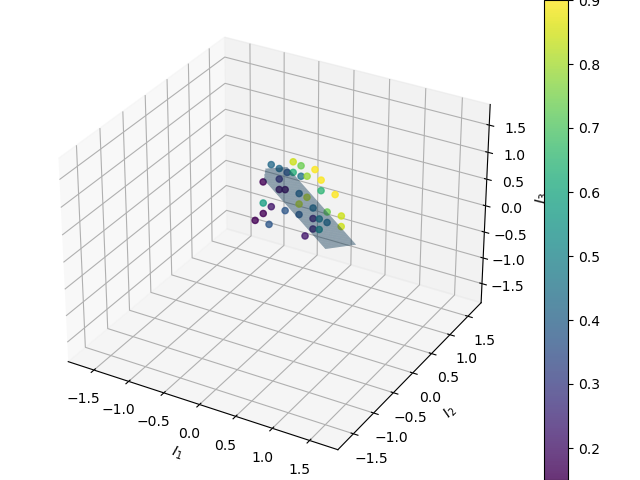

[nan]
[-7.79321846  6.31621662  2.03405466  2.59269247]


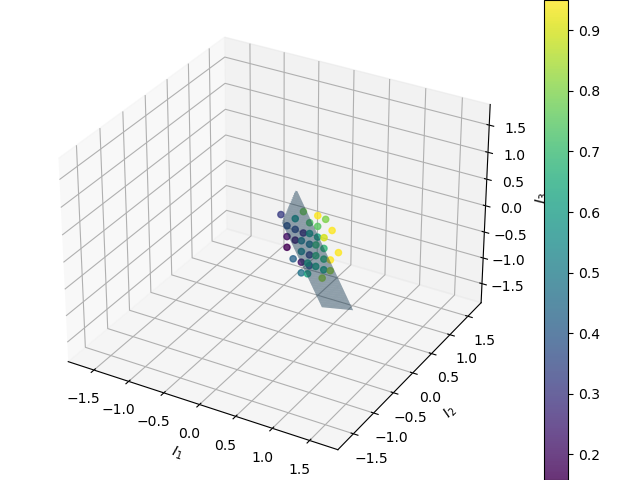

[nan]
[nan]
[-7.90266734  6.52366331  1.17089834 -0.10741933]


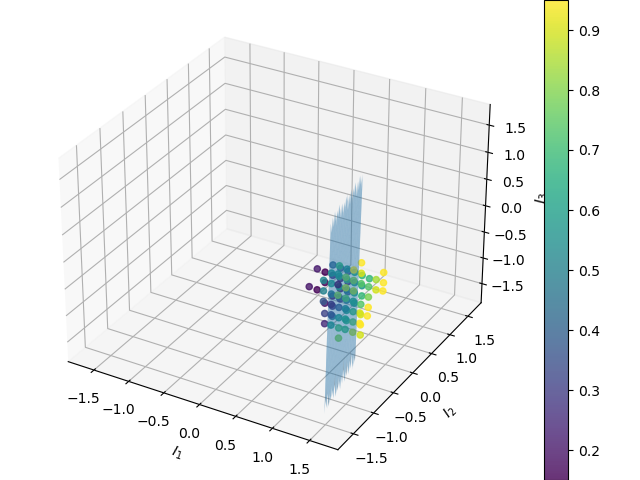

[nan]
[-7.51136949  5.55961811  0.82891938 -3.07845725]


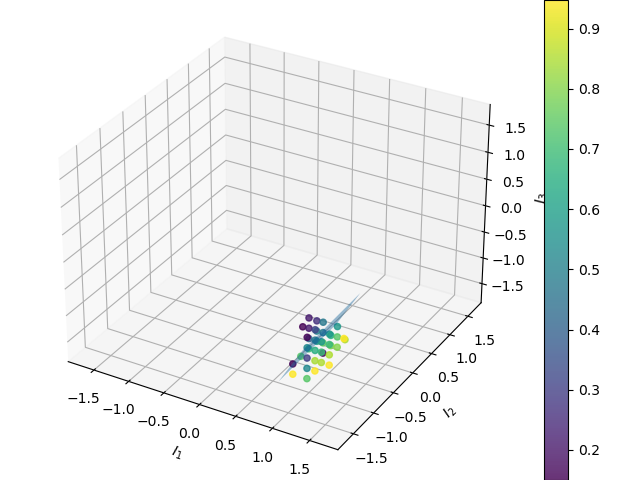

[nan]
[nan]
[-11.66423838  10.0347533    2.62317679   0.80751366]


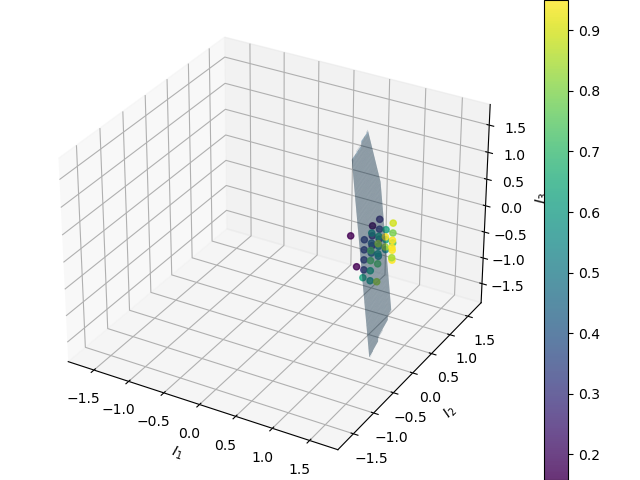

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-6.34503525  5.87982266  1.40650591  0.64623204]


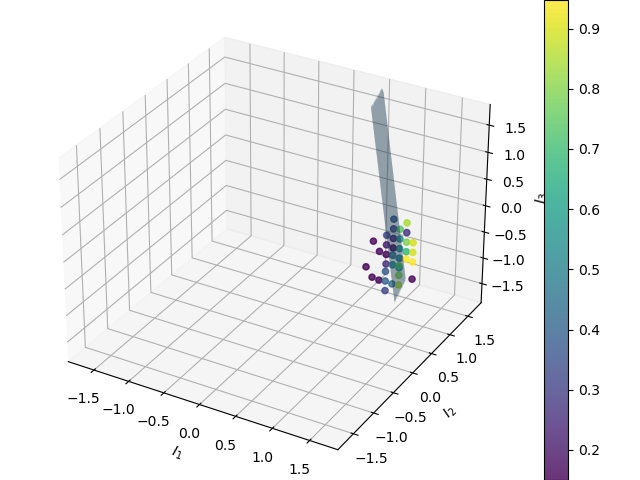

[nan]
[nan]
[-7.07563981  6.85301571  0.60254064  0.22766544]


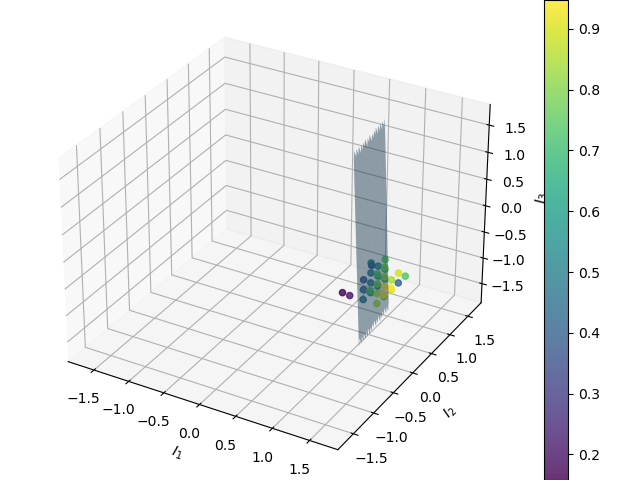

[-7.16541854  4.58937914 -0.566725   -2.21344362]


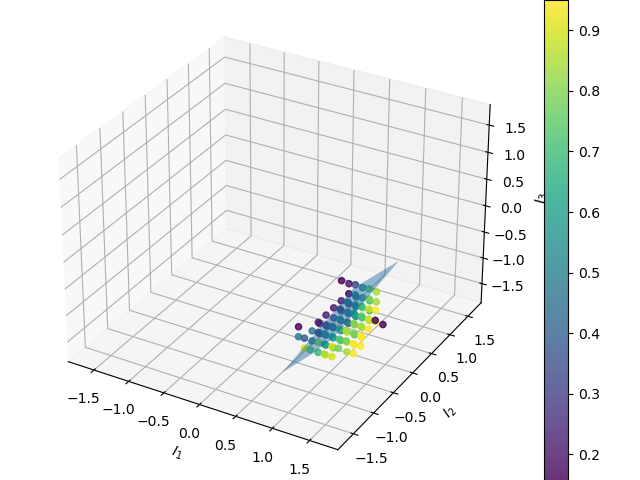

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]

1194
0.0009277084384098355
left
610
0.0022065871021260675
left
342
0.002865231325588913
left
135
0.0427758817343471
left
69
0.09110479183238385
left
32
0.1282517748062274
right
37
0.07466916197000839
left
20
0.11201352986251278
right
17
0.06260132531089757
right
66
0.05087746206205179
left
30
0.051860111823748944
left
14
0.09919941636000518
right
16
0.09378578587343711
right
36
0.13795960440285238
right
207
0.007652261628746215
left
96
0.01637555317223327
left
48
0.09557809007484919
left
27
0.1284558681113962
right
21
0.10957471422964238
right
48
0.01938728519291033
left
23
0.151895806817804
right
25
0.005464834777704319
right
111
0.025432833034364832
left
81
0.012066020484124307
left
42
0.011419379139721464
left
25
0.02585128291546257
right
17
0.010901352914620466
right
39
0.020529279479600038
left
15
0.010344164176842807
right
24
0.02536724890539699
right
30
0.11289303212021129
right
268
0.05861607387987744
left

/tmp/ipykernel_48692/1134596097.py:61: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


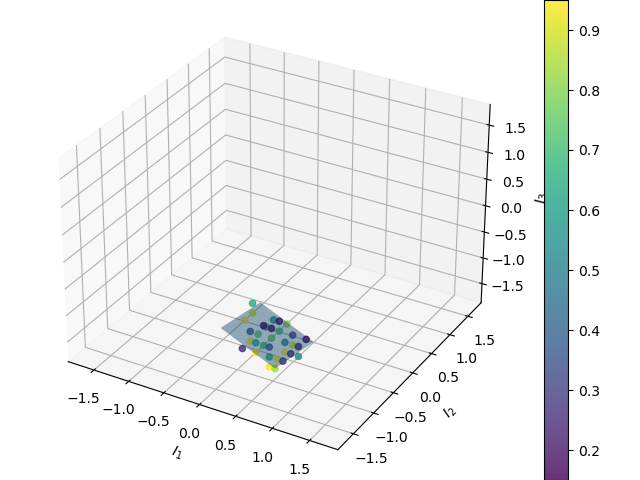

[nan]
[nan]
[nan]
[nan]
[-10.13210535  -2.98396411  -7.21130246  -1.75088633]


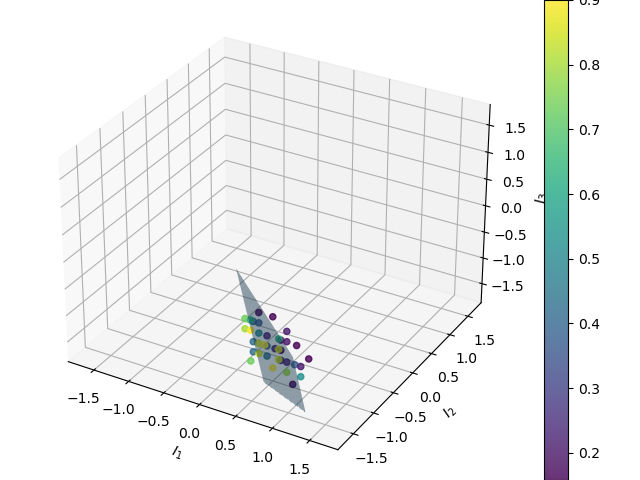

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-11.19120811  -2.7390499    0.24200298 -11.11005435]


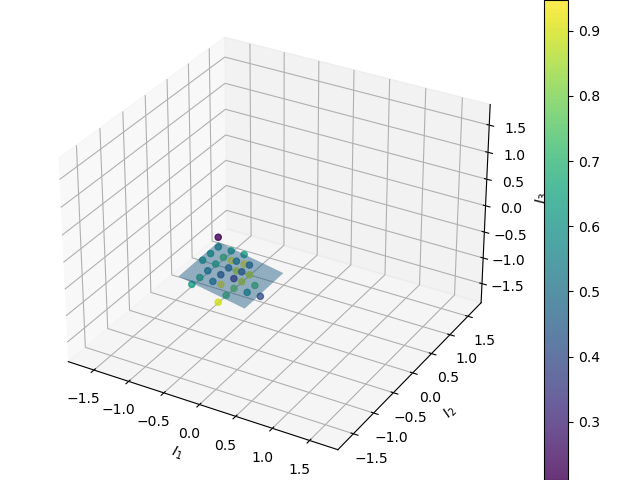

[-9.36138641 -1.34538612  2.91166836 -8.22923453]


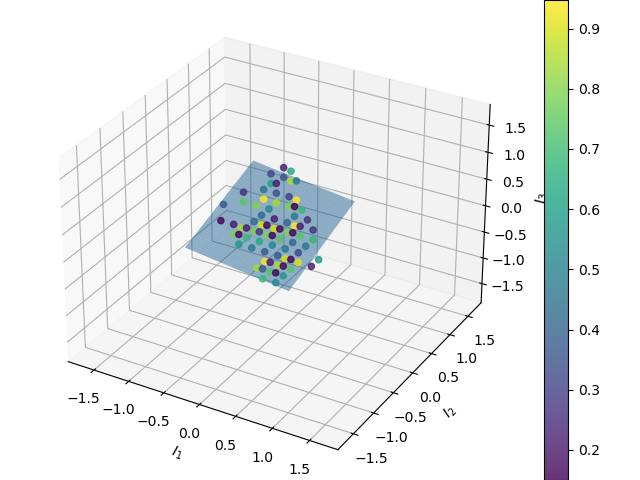

[-8.91270964  0.31546765  5.03929474 -3.5030975 ]


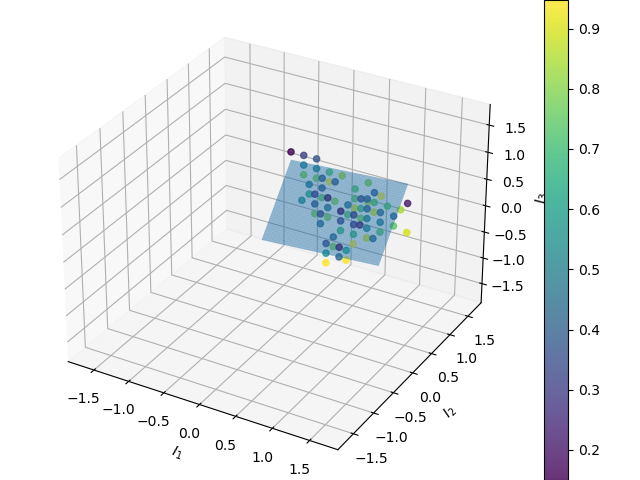

[-12.38399056  -0.43303387   7.30602322  -5.84060402]


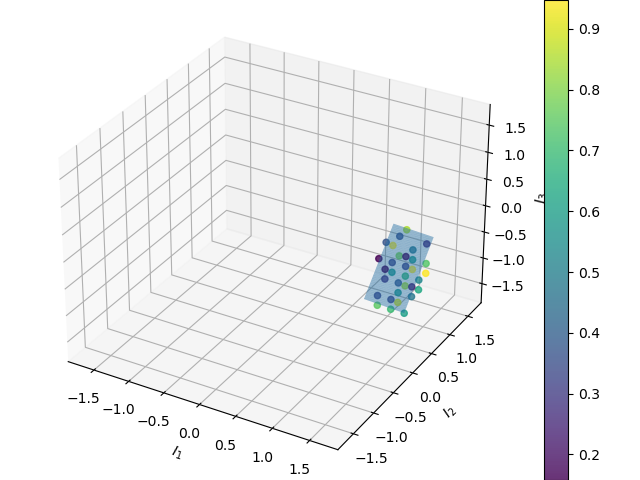

[nan]
[nan]
[-12.81531066  -2.9522085    3.50453491 -10.26311327]


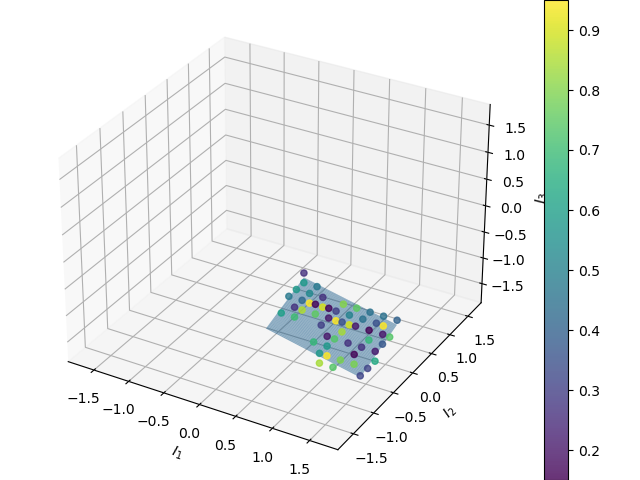

[-12.54468201   2.52614344  -0.71652709   9.71699965]


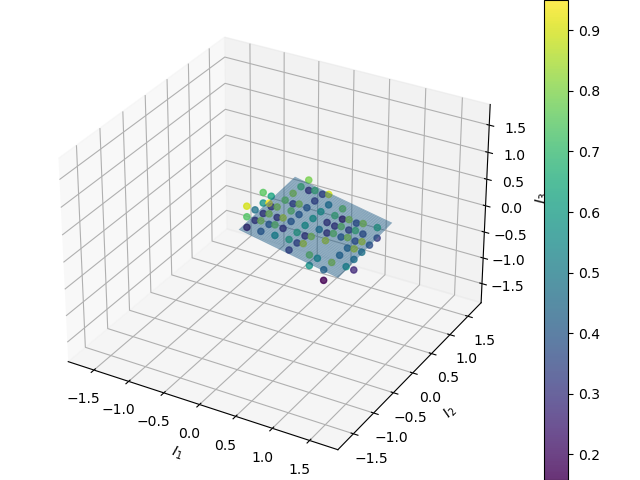

[nan]
[nan]
[-11.37288319   1.69835155  -4.47679274   3.8203267 ]


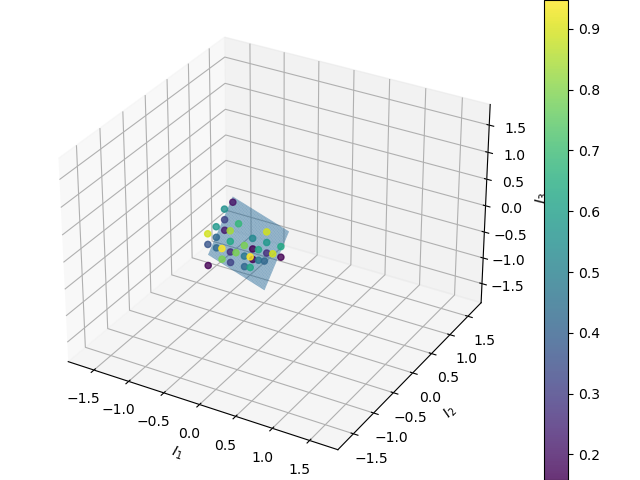

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-10.32086501   3.42965446   1.22988745   7.60222377]


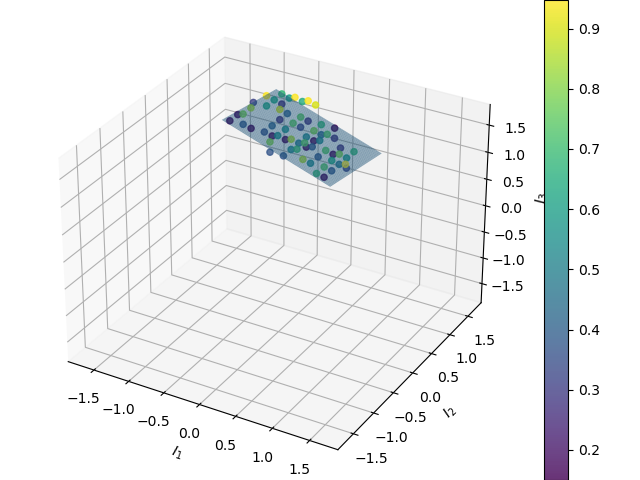

[nan]
[nan]
[-9.92621167  0.66368387  6.56286266 -0.02832794]


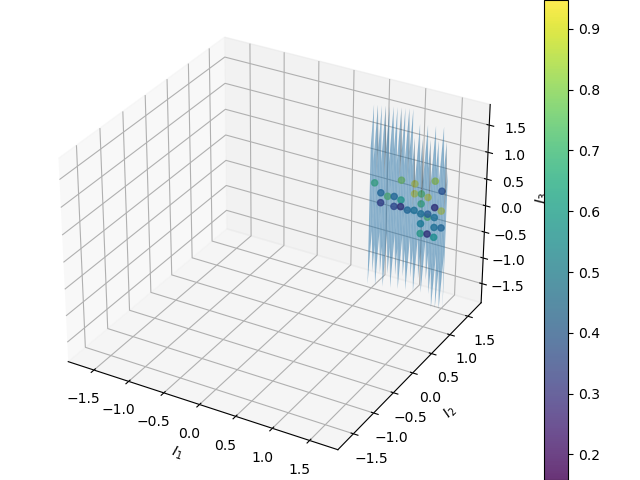

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
0
Optimal value 0.0037016360111660736
optimal p_t 0.997411023462467
optimal p_n 0.0011047175251867498
optimal T_t -5.953900306887354
optimal T_n -6.807060281831981
[-1.78124978  0.08987713  0.76647643]
1
Optimal value 0.14711164480667632
optimal p_t 0.9289081442329616
optimal p_n 0.0659259531217125
optimal T_t -2.5700370738906564
optimal T_n -2.651023524597271
[-1.7812499   1.29547765  1.5767826 ]
2
Optimal value 0.010489591549028102
optimal p_t 0.9935144679390018
optimal p_n 0.003946089473295026
optimal T_t -5.031674765206295
optimal T_n -5.531076301382723
[-1.78124988 -0.04891808  0.60936046]
3
Optimal value 1.3988153850888247
optimal p_t 0.5134511462598214
optimal p_n 0.3109200541690901
optimal T_t -0.05381757073605743
optimal T_n -0.7958214773834652
[-1.11692105  0.68144248 -0.61715829]
4
Optimal value 0.027199016603199816
optimal p_t 0.9789916403180565
optimal p_n 0.005707077030723465
optimal T_t -3.8416026648899844
optimal T_n -5.16032486531014

/tmp/ipykernel_48692/1802531275.py:47: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


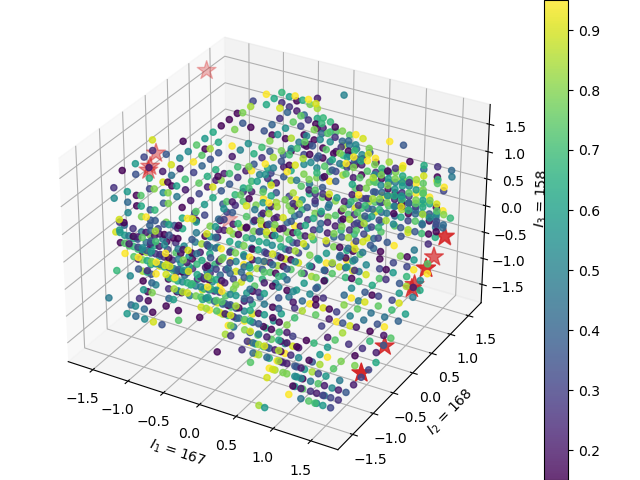

/tmp/ipykernel_48692/1802531275.py:67: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


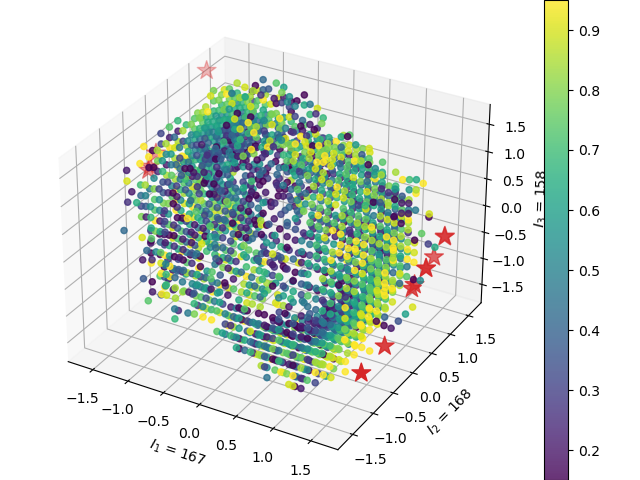

In [31]:
Imax = 1.78125
debug = True
for m in range(len(all_targets)):
    print(m)
    if debug:
        m = 0
    
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, spont_limit=0.15, noise_limit=0.15, show_plots=debug)
    
    print(best_1elec)
    
    t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                     targets, downsample=False, downsample_trials=10, 
                                                     downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                     min_points_per_cluster=30, show_plots=debug, verbose=debug)
    nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                        nontargets, downsample=False, downsample_trials=10, 
                                                        downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                        min_points_per_cluster=30, show_plots=debug, verbose=debug)
    
    target_combos_flat = cartesian_product_pp(t_weights)
    target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))
    
    nt_weights = np.vstack((nt_weights))

    selec_vals, x_vals = computeSelecVec(target_combos, nt_weights, I_max=Imax, verbose=debug)
    print(selec_vals, x_vals)
    selec_vec = x_vals[np.argsort(selec_vals)[-1]]
    print(selec_vec)
    best_multielec = np.amax(selec_vals)
    print(best_multielec)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    multi_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()

    if debug:
        break

In [28]:
selec_vals

array([0.83238615, 0.99670578, 0.99085552, 0.40105277, 0.97766294,
       0.98119882, 0.9892174 , 0.8851183 , 0.87870232, 0.97738819,
       0.97777942, 0.99639579, 0.98654315, 0.98770565])

In [29]:
selec_comparison

[(0.3632509971148007, 0.9967057779633591, 'ON/OFF')]

In [ ]:
plt.figure()
for i in range(len(selec_comparison)):
    if selec_comparison[i][2] == 'ON/OFF':
        color = 'tab:blue'
    if selec_comparison[i][2] == 'ON/ON':
        color = 'tab:red'
    if selec_comparison[i][2] == 'OFF/OFF':
        color = 'tab:orange'
    if selec_comparison[i][2] == 'mixed':
        color = 'tab:purple'
    plt.scatter(np.array(selec_comparison)[i, 0].astype(float), 
                np.array(selec_comparison)[i, 1].astype(float), alpha=0.5, c=color)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')
plt.xlabel('Single-electrode selectivity')
plt.ylabel('Triplet selectivity')
leg = plt.legend(['OFF/OFF'])#, 'ON/ON', 'OFF/OFF', 'mixed'])
leg.legendHandles[0].set_color('tab:orange')
# leg.legendHandles[1].set_color('tab:red')
# leg.legendHandles[2].set_color('tab:orange')
# leg.legendHandles[3].set_color('tab:purple')